In [20]:
import numpy as np

from astropy import table
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u

In [2]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

matplotlib.__version__

'2.0.0'

In [3]:
emm_lines = Table.read('emm_lines_eteq.fits.gz')
print(len(emm_lines))
emm_lines[:2]

554682


specObjID,ra,dec,z,zErr,class,subClass,plate,mjd,fiberID,EW_OII_3726,EW_OII_3726_Err,Flux_OII_3726,Flux_OII_3726_Err,EW_OII_3728,EW_OII_3728_Err,Flux_OII_3728,Flux_OII_3728_Err,EW_OIII_5006,EW_OIII_5006_Err,Flux_OIII_5006,Flux_OIII_5006_Err,EW_Ha_6562,EW_Ha_6562_Err,Flux_Ha_6562,Flux_Ha_6562_Err,psfMag_u,psfMagErr_u,cModelMag_u,cModelMagErr_u,psfMag_g,psfMagErr_g,cModelMag_g,cModelMagErr_g,psfMag_r,psfMagErr_r,cModelMag_r,cModelMagErr_r,psfMag_i,psfMagErr_i,cModelMag_i,cModelMagErr_i,psfMag_z,psfMagErr_z,cModelMag_z,cModelMagErr_z
int64,float64,float64,float32,float32,str32,str32,int16,int32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
1721614531295209472,57.280175,0.078644,0.160064,1.38945e-05,GALAXY,,1529,52930,413,12.0192,4.6861,70.8995,24.4747,8.80509,3.24338,46.0051,15.6661,1.67083,0.588608,16.7912,5.90985,24.0916,1.55255,213.704,13.4401,22.1782,0.142874,21.0619,0.119805,20.9949,0.0310757,19.5871,0.0201374,20.2733,0.0229295,18.7679,0.0146811,19.7395,0.0206654,18.2853,0.0134972,19.3003,0.0491124,18.1697,0.0399003
1838757051015129088,58.142863,0.166763,0.223449,1.89855e-05,GALAXY,STARFORMING,1633,52998,591,2.88139,9.60235,16.8976,56.2384,6.68888,7.75947,35.1931,40.6505,2.34181,0.733501,21.3054,6.66257,21.1187,1.36395,172.305,10.9527,22.816,0.239548,20.8299,0.134807,21.365,0.0404665,20.1606,0.0288153,20.4778,0.0273307,19.0874,0.0166021,19.9561,0.0255765,18.6287,0.014943,19.5993,0.0614202,18.2929,0.0448675


In [4]:
cuts1 = (emm_lines['psfMag_u'] > 0)&(emm_lines['psfMag_g'] > 0)
ug = emm_lines['cModelMag_u']-emm_lines['cModelMag_g']
gr = emm_lines['cModelMag_g']-emm_lines['cModelMag_r']
cuts2 = (ug > -0.5) * (ug < 3.5 ) * (gr > -0.75)*( gr < 2)

decentcuts = cuts1&cuts2
decent_emms = emm_lines[decentcuts]

In [5]:
random_sample = np.random.permutation(len(decent_emms))[:10]
random_emms = decent_emms[random_sample]

# Display images 

In [14]:
def make_cutout_comparison_table(dcat, dhtml=True, doprint=True):
    """
    Produces a table comparing DECaLS and SDSS objects side-by-side

    `dcat` should be a *DECaLS* catalog, not SDSS
    """
    de_cutout_url = 'http://legacysurvey.org/viewer/jpeg-cutout/?ra={0.ra.deg}&dec={0.dec.deg}&layer=decals-dr3&pixscale=0.1&bands=grz'
    sd_cutout_url = 'http://legacysurvey.org/viewer/jpeg-cutout/?ra={0.ra.deg}&dec={0.dec.deg}&layer=sdssco&pixscale=0.1&bands=gri'

    if doprint:
        print('put this into http://skyserver.sdss.org/dr13/en/tools/chart/listinfo.aspx')
        print('name ra dec')

    tabrows = []
    for row in dcat:
        dviewurl = 'http://legacysurvey.org/viewer?ra={}&dec={}'.format(row['ra'], row['dec'])
        sviewurl = 'http://skyserver.sdss.org/dr12/en/tools/chart/navi.aspx?ra={}&dec={}'.format(row['ra'], row['dec'])
        specurl = 'http://skyserver.sdss.org/dr13/en/get/SpecById.ashx?id={}'.format(row['specObjID'])
        sc = SkyCoord(row['ra'], row['dec'], unit=u.deg)
        objstr = '{}<br>RA={:.4f}<br>Dec={:.4f}<br>class:{} sub:{}<br>{},{},{}<br><a href="{}">spectrum</a>'.format(row['specObjID'], row['ra'], row['dec'], 
                                                                                       row['class'], row['subClass'],
                                                                                       row['plate'], row['mjd'], row['fiberID'],
                                                                                       specurl)
                                                                                       
        deimg = '<a href="{}"><img src="{}"></a>'.format(dviewurl, de_cutout_url.format(sc))
        sdimg = '<a href="{}"><img src="{}"></a>'.format(sviewurl, sd_cutout_url.format(sc))
        specimg = '<a href="{}"><img src="{}"></a>'.format(specurl, specurl)
        tabrows.append('<tr><td>{}</td><td>{}</td><td>{}</td><td>{}</td></tr>'.format(objstr, deimg, sdimg, specimg))
        if doprint:
            print(str(row['specObjID']), row['ra'], row['dec'])

    htmlstr = """
    <table>

    <tr>
    <th>obj</th>
    <th>DECALS</th>
    <th>SDSS</th>
    </tr>

    {}
    </table>
    """.format('\n'.join(tabrows))

    if dhtml:
        from IPython import display
        return display.HTML(htmlstr)
    else:
        return htmlstr
make_cutout_comparison_table(random_emms)

put this into http://skyserver.sdss.org/dr13/en/tools/chart/listinfo.aspx
name ra dec
2055905658103949312 215.63813 5.6437496
2652782147126978560 160.49453 27.710422
2286748130210768896 194.00215 35.507376
1806108978715846656 168.64724 12.867159
3128972399429576704 225.15315 17.561568
1518988005082163200 218.95647 40.473452
1099017987538577408 257.63549 32.459916
2048098043500193792 230.79296 6.8872756
1115798464056289280 141.06272 5.2174002
2412923967082883072 221.71756 24.857451


# Cross match 

In [30]:
def fluxivar_to_mag_magerr(flux, ivar, deunit=True):
    """
    returns mag, mag_err as Quantities
    """
    flux = u.Quantity(flux, copy=False)
    ivar = u.Quantity(ivar, copy=False)
    if deunit:
        flux = u.Quantity(flux.value, u.dimensionless_unscaled)
        ivar = u.Quantity(ivar.value, u.dimensionless_unscaled)

    mag = np.array(22.5 - 2.5*np.log10(flux))
    flux_err = ivar**-0.5
    mag_err = 2.5/np.log(10) * flux_err/flux
    return mag*u.mag, mag_err.value*u.mag

In [35]:
decals = Table.read('decals_specObjId.dat', format='ascii.csv')

for band in 'grz':
    mag, _ = fluxivar_to_mag_magerr(decals['decals_'+band], 0)
    decals['decals_mag_'+band] = mag

decals

/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in log10
/Users/erik/miniconda3/lib/python3.5/site-packages/astropy/units/quantity.py:885: RuntimeWarning: divide by zero encountered in power
  return super(Quantity, self).__pow__(other)


specobjid,ra,dec,decals_g,decals_r,decals_z,nobs_g,nobs_r,nobs_z,decals_mag_g,decals_mag_r,decals_mag_z
,,,,,,,,,mag,mag,mag
int64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64
4947293900253302784,32.9462762705,-7.17639316206,1.14344,1.73801,2.9481,2,1,3,22.3544665482,21.8998693227,21.3261444731
4949685336449880064,32.9744841915,-7.42410548438,7.22819,33.8469,77.1813,4,3,3,20.3524261003,18.6762027543,17.7812197767
4947295549520744448,33.0168249772,-7.4574844026,4.22933,4.48525,5.74506,4,3,3,20.9343210676,20.8705333628,20.6017635782
4949686435961507840,33.0175057108,-7.37864894021,117.426,298.932,598.452,4,3,3,17.3255893317,16.3110689806,15.5574266932
4949685611327787008,32.9967191359,-7.36394690587,1.471,7.26294,21.5836,4,3,3,22.0809683182,20.347218859,19.1646902905
4947282630259118080,33.1183012504,-7.38385249412,0.884638,5.57892,21.1256,4,3,3,22.6330860232,20.6336246655,19.1879773689
4949683137426624512,33.1327914304,-7.38307570164,163.105,367.145,685.202,4,3,3,16.9688318135,16.0879059547,15.4104534452
4947282355381211136,33.1863820455,-7.39417408943,0.744934,1.35342,3.55076,3,2,2,22.8197055084,22.1714185252,21.1241967029


In [37]:
decals['specobjid'].name = 'specObjID'

joinedde = table.join(decent_emms, decals, keys='specObjID')
joinedde

specObjID,ra_1,dec_1,z,zErr,class,subClass,plate,mjd,fiberID,EW_OII_3726,EW_OII_3726_Err,Flux_OII_3726,Flux_OII_3726_Err,EW_OII_3728,EW_OII_3728_Err,Flux_OII_3728,Flux_OII_3728_Err,EW_OIII_5006,EW_OIII_5006_Err,Flux_OIII_5006,Flux_OIII_5006_Err,EW_Ha_6562,EW_Ha_6562_Err,Flux_Ha_6562,Flux_Ha_6562_Err,psfMag_u,psfMagErr_u,cModelMag_u,cModelMagErr_u,psfMag_g,psfMagErr_g,cModelMag_g,cModelMagErr_g,psfMag_r,psfMagErr_r,cModelMag_r,cModelMagErr_r,psfMag_i,psfMagErr_i,cModelMag_i,cModelMagErr_i,psfMag_z,psfMagErr_z,cModelMag_z,cModelMagErr_z,ra_2,dec_2,decals_g,decals_r,decals_z,nobs_g,nobs_r,nobs_z,decals_mag_g,decals_mag_r,decals_mag_z
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,mag
int64,float64,float64,float32,float32,str32,str32,int16,int32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64
299491051834468352,146.63167,-0.98827781,0.0526543,8.61411e-06,GALAXY,STARFORMING,266,51630,6,15.0786,7.45907,116.963,52.5967,7.3919,6.54488,51.3941,44.9019,5.0994,0.600685,52.2942,6.01457,22.5591,1.53839,181.837,11.5996,20.9508,0.0706373,19.4101,0.069315,19.9324,0.0216804,18.3243,0.0100585,19.5894,0.0199216,17.8438,0.00909412,19.146,0.0214541,17.4926,0.0102784,19.0319,0.0474894,17.4458,0.0318765,146.631671307,-0.988281838751,48.4566,80.7645,119.534,2,2,3,18.2866176545,17.7319487281,17.3062713683
299492426224003072,146.9341,-0.67040397,0.12127,2.83749e-05,GALAXY,,266,51630,11,29.4666,2.26439,295.004,0.0,2.17498,5.44815,20.3465,50.9314,0.447902,0.242989,14.6469,7.94263,0.634787,0.417594,22.4035,14.7362,21.0201,0.0774618,19.9392,0.0729541,19.2085,0.0172487,17.9803,0.00773087,18.0703,0.0135182,16.8473,0.00491148,17.6471,0.0152425,16.3618,0.00445552,17.1969,0.0196973,15.998,0.00878877,146.934133085,-0.67039626939,67.077,194.019,415.05,2,2,5,17.9335659233,16.7803893454,15.9547489545
299493800613537792,146.85983,-0.80890165,0.12659,4.93195e-05,GALAXY,,266,51630,16,4.57225,3.08527,59.6464,39.494,17.9839,11.2093,214.994,131.755,2.34502,0.894769,88.8823,33.8875,0.877061,0.231584,34.5143,9.09678,22.3021,0.226135,20.7563,0.16804,20.2416,0.0231042,18.4228,0.0137163,18.8207,0.0153337,17.3099,0.0072839,18.2359,0.0162379,16.8708,0.00611934,17.6886,0.0222161,16.4838,0.0124948,146.859834139,-0.808902966372,33.0827,117.193,298.3,3,3,5,18.7009976333,17.3277458205,16.3133668666
299494075491444736,146.59272,-0.76025604,0.0649592,9.29493e-06,GALAXY,STARFORMING,266,51630,17,12.7646,5.3433,214.993,77.7969,0.355534,25.3782,5.29916,378.255,1.48152,0.342288,40.633,9.36119,15.6718,0.576242,367.88,12.3855,20.58,0.058397,18.9408,0.0434393,19.2808,0.0158892,17.4192,0.00616957,18.5165,0.0133129,16.8089,0.00530233,18.1885,0.0146285,16.3723,0.005092,17.9016,0.0218403,16.1768,0.0124609,146.592743514,-0.76026245596,104.548,204.226,346.812,1,2,4,17.451710677,16.7247224218,16.1497647099
299494900125165568,146.60721,-1.240753,0.0906017,2.59476e-05,GALAXY,,266,51630,20,0.369924,0.0702918,4.10243,0.0,3.803,2.76272,37.4265,26.5908,4.63387,0.0806928,131.956,0.0,0.385017,0.194841,11.1985,5.66483,20.818,0.0691707,18.9376,0.0482862,19.1213,0.0185167,17.3325,0.00646386,18.2052,0.0143116,16.3584,0.00453796,17.7442,0.0148084,15.9412,0.00442062,17.4475,0.0186374,15.6276,0.00994783,146.607220599,-1.24075678879,118.336,287.981,544.502,2,2,5,17.3172077871,16.3515904114,15.6600013018
299495449880979456,147.18679,-0.49381256,0.0903171,2.5099e-05,GALAXY,,266,51630,22,13.4216,19.4031,338.959,488.051,9.97666,3.4158,230.617,74.7794,1.89183,0.770095,105.037,42.7409,4.60806,0.369027,242.001,18.8527,21.5495,0.112993,18.5038,0.0703471,19.7032,0.0224147,17.4681,0.00843626,18.578,0.0180934,16.6957,0.0054541,18.1153,0.018212,16.1848,0.00492226,17.6316,0.0216008,15.8419,0

(-0.2, 0.2)

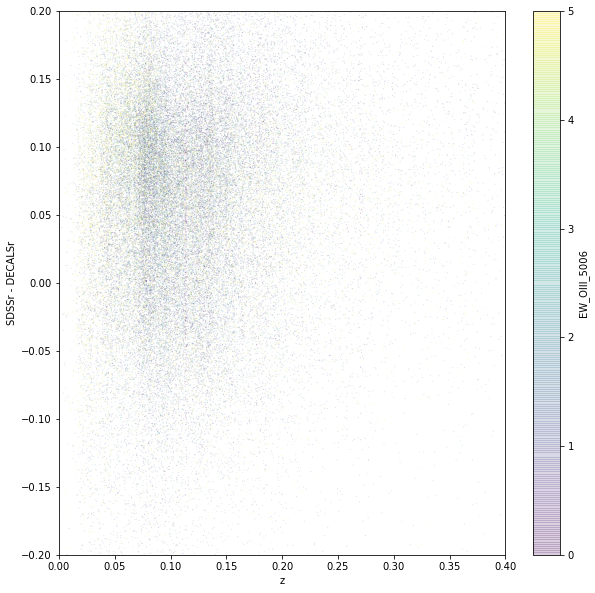

In [54]:
diff = joinedde['cModelMag_r']-joinedde['decals_mag_r']

subset = slice(0, 100000)

plt.figure(figsize=(10, 10))
plt.scatter(joinedde['z'][subset], diff[subset], c=joinedde['EW_OIII_5006'][subset], alpha=.2, s=1, vmax=5, lw=0)
plt.colorbar().set_label('EW_OIII_5006')

plt.xlabel('z')
plt.ylabel('SDSSr - DECALSr')

plt.xlim(0, .4)
plt.ylim(-.2,.2)

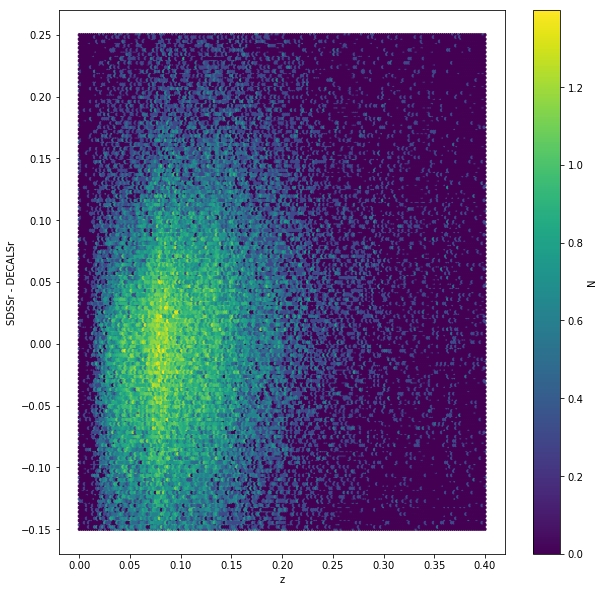

In [80]:
diff = joinedde['cModelMag_g']-joinedde['decals_mag_g']

subset = slice(None)

plt.figure(figsize=(10, 10))
plt.hexbin(joinedde['z'][subset], diff[subset], extent=(0, .4,-.15, .25), bins='log', gridsize=200)
plt.colorbar().set_label('N')

plt.xlabel('z')
plt.ylabel('SDSSr - DECALSr')


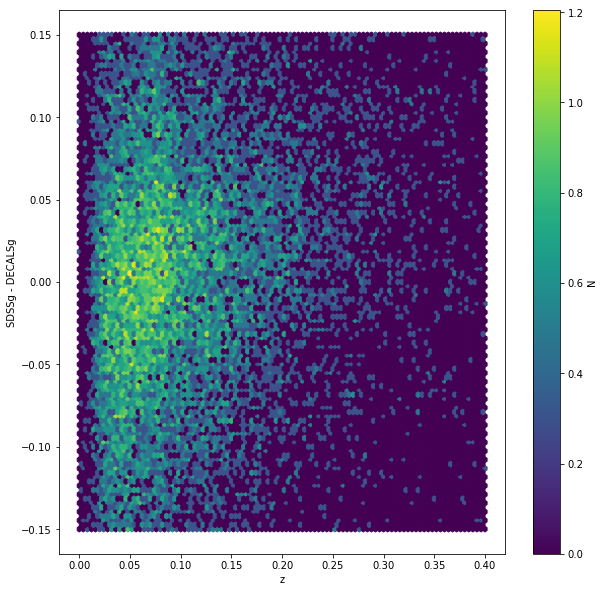

In [81]:
diff = joinedde['cModelMag_g']-joinedde['decals_mag_g']

subset = joinedde['EW_OIII_5006']>5

plt.figure(figsize=(10, 10))
plt.hexbin(joinedde['z'][subset], diff[subset], extent=(0, .4,-.15, .15), bins='log', gridsize=100)
plt.colorbar().set_label('N')

plt.xlabel('z')
plt.ylabel('SDSSg - DECALSg')


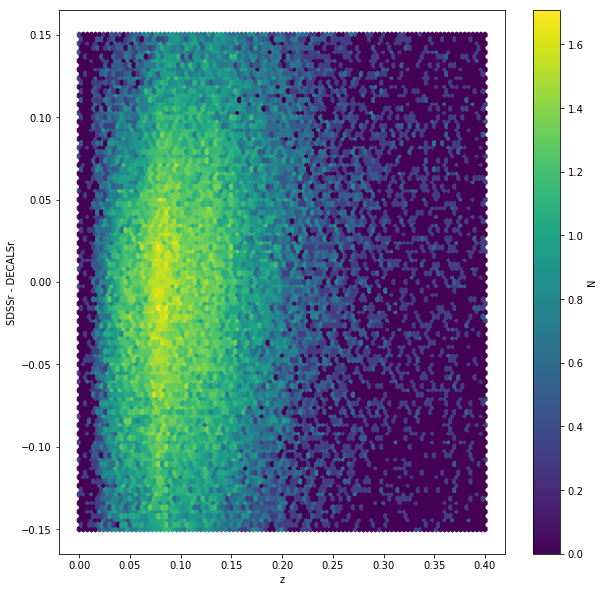

In [82]:
diff = joinedde['cModelMag_g']-joinedde['decals_mag_g']

subset = joinedde['EW_OIII_5006']<5

plt.figure(figsize=(10, 10))
plt.hexbin(joinedde['z'][subset], diff[subset], extent=(0, .4,-.15, .15), bins='log', gridsize=100)
plt.colorbar().set_label('N')

plt.xlabel('z')
plt.ylabel('SDSSr - DECALSr')


/Users/erik/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in true_divide
/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in true_divide
/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/erik/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in true_divide


/Users/erik/miniconda3/lib/python3.5/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


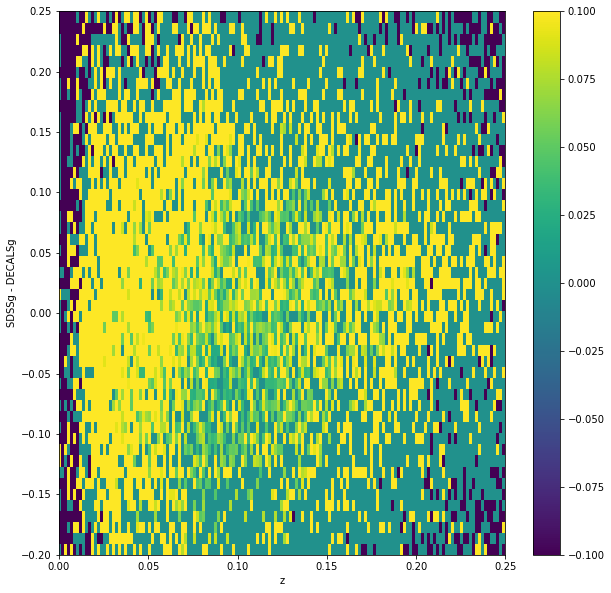

In [151]:
diff = joinedde['cModelMag_g']-joinedde['decals_mag_g']

brightline = joinedde['EW_OIII_5006']>10
faintline = ~brightline

x = (joinedde['z']+1)*5007
x= joinedde['z']


#Nall, xe, ye = np.histogram2d(x, diff, bins=[np.linspace(5000, 6500, 150), np.linspace(-.2,.2,50)])
Nall, xe, ye = np.histogram2d(x, diff, bins=[np.linspace(0, 0.25, 150), np.linspace(-.2,.25,50)])
Nbright, xe, ye = np.histogram2d(x[brightline], diff[brightline], bins=[xe, ye])
Nfaint, xe, ye = np.histogram2d(x[faintline], diff[faintline], bins=[xe, ye])

logNbrightnorm = np.log10(Nbright.T/np.sum(N, axis=1) + 1)
logNfaintnorm = np.log10(Nfaint.T/np.sum(N, axis=1) + 1)
ratio = (Nbright/Nfaint).T

plt.figure(figsize=(10, 10))
plt.pcolor(xe,ye, ratio)
plt.colorbar()

ratio[np.isnan(ratio)]=0
#plt.plot((xe[:-1]+xe[1:])/2, np.mean(ratio, axis=0), c='w', lw=3)


plt.xlabel('z')
plt.ylabel('SDSSg - DECALSg')